In [1]:
%env CUDA_VISIBLE_DEVICES=1
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import flax.linen as nn
jax.devices()

env: CUDA_VISIBLE_DEVICES=1
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


[cuda(id=0)]

# data

(3,) (1024, 1) (1024, 1)


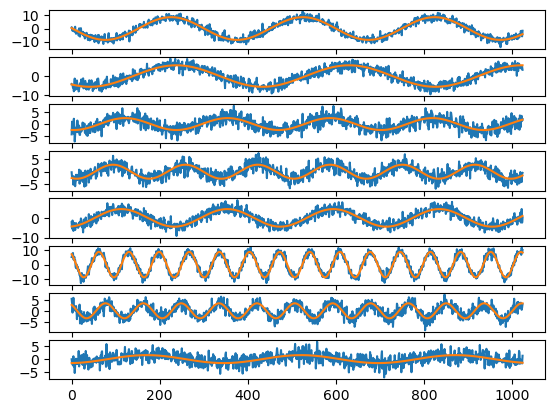

In [2]:
from datasets import SingleSinusoidDataset

dataset = SingleSinusoidDataset(noise_psd=lambda f: 3*jnp.ones_like(f))
batch = dataset.get_batch(jr.key(0), 8)
for i, (params, clean, noisy) in enumerate(zip(*batch)):
    plt.subplot(8, 1, i+1)
    plt.plot(noisy)
    plt.plot(clean)
print(params.shape, clean.shape, noisy.shape)

# model

In [3]:
from models import TimeEmbed, ParamEmbed, PosEmbed
from models import Patchify, DiTBlock
from flow_matching import CNF, Trainer


class SinCNF(CNF):
    depth: int
    dim: int
    heads: int

    @nn.compact
    def __call__(self, t, x, d):
        c = TimeEmbed(self.dim)(t) + ParamEmbed(self.dim)(x)
        d = Patchify(self.dim, patch_size=16)(d)
        d = d + PosEmbed(self.dim, max_period=1000)(d)

        for _ in range(self.depth):
            d = DiTBlock(self.heads)(d, c)

        h = d[..., -1, :]
        h = nn.Dense(x.shape[-1])(h)
        return h

    def target_flow(self, x0, x1):
        target_flow = x1 - x0
        d_phi = target_flow[..., -1]
        d_phi = jnp.where(d_phi < -jnp.pi, d_phi + 2 * jnp.pi, d_phi)
        d_phi = jnp.where(d_phi > jnp.pi, d_phi - 2 * jnp.pi, d_phi)
        target_flow = target_flow.at[..., -1].set(d_phi)
        return target_flow

# train

In [4]:
def to_flow_space(params):
    amp, omg, phi = jnp.split(params, 3, axis=-1)
    flow_params = [jnp.log(amp), jnp.log(omg), phi]
    return jnp.concatenate(flow_params, axis=-1)


def from_flow_space(flow_params):
    log_amp, log_omg, phi = jnp.split(flow_params, 3, axis=-1)
    phi = jnp.where(phi > jnp.pi, phi - 2 * jnp.pi, phi)
    phi = jnp.where(phi < -jnp.pi, phi + 2 * jnp.pi, phi)
    params = [jnp.exp(log_amp), jnp.exp(log_omg), phi]
    return jnp.concatenate(params, axis=-1)


def flow_matching_batch(key, batch_size):
    key_t, key_x0, key_x1 = jr.split(key, 3)
    # t = jax.nn.sigmoid(jr.normal(key_t, (batch_size,)))
    t = jr.uniform(key_t, (batch_size,))

    params_x0, clean_x0, data_x0 = dataset.get_batch(key_x0, batch_size)
    params_x1, clean_x1, data_x1 = dataset.get_batch(key_x1, batch_size)

    # flow in easier space
    cond = data_x1
    x0 = to_flow_space(params_x0)
    x1 = to_flow_space(params_x1)
    return t, x0, x1, cond

In [5]:
model = SinCNF(depth=4, dim=64, heads=8)
trainer = Trainer(
    get_batch_fn=flow_matching_batch,
    optimizer=optax.adam(3e-4),
    epochs=1000,
    epoch_steps=32,
    batch_size=4*1024,
)
params, opt_state, losses = trainer.fit(model)

100%|██████████| 1000/1000 [1:09:03<00:00,  4.14s/it, loss=0.036265656]


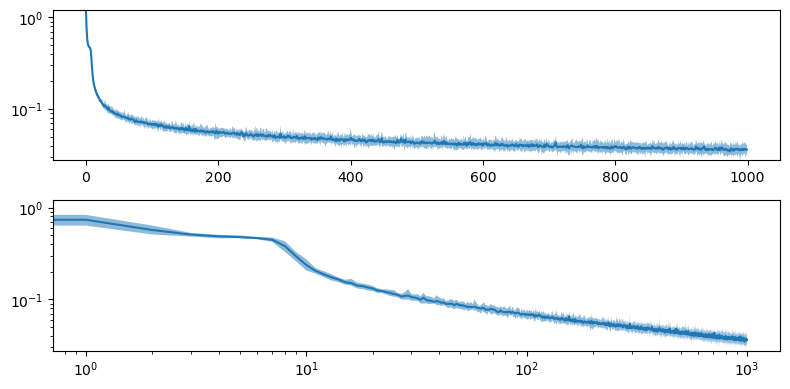

In [6]:
def plot(losses, loglog=False):
    mean = losses.mean(axis=-1)
    min, max = losses.min(axis=-1), losses.max(axis=-1)
    (plt.loglog if loglog else plt.semilogy)(losses.mean(axis=-1))
    plt.fill_between(range(losses.shape[0]), min, max, alpha=0.5)
    plt.ylim(losses.min(), mean.max())

plt.figure(figsize=(8, 4))
plt.subplot(2, 1, 1)
plot(losses, loglog=False)
plt.subplot(2, 1, 2)
plot(losses, loglog=True)
plt.tight_layout()

# results

SAMPLING USING CNF
SAMPLING USING FISHER


/tmp/ipykernel_1001805/1208148818.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))


SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:07<00:00, 128.20it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 128/128 [00:01<00:00, 116.66it/s]


SAMPLING USING CNF


/tmp/ipykernel_1001805/1208148818.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))


SAMPLING USING FISHER
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:08<00:00, 120.19it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 128/128 [00:01<00:00, 112.26it/s]


SAMPLING USING CNF


/tmp/ipykernel_1001805/1208148818.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))


SAMPLING USING FISHER
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:08<00:00, 120.30it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 128/128 [00:01<00:00, 116.40it/s]


SAMPLING USING CNF


/tmp/ipykernel_1001805/1208148818.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))


SAMPLING USING FISHER
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:07<00:00, 131.60it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 128/128 [00:00<00:00, 129.47it/s]


SAMPLING USING CNF


/tmp/ipykernel_1001805/1208148818.py:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))


SAMPLING USING FISHER
SAMPLING USING MCMC


100%|██████████| 1000/1000 [00:08<00:00, 118.54it/s]


Finished initial run, burn-in dropped and starting real run


100%|██████████| 128/128 [00:01<00:00, 117.60it/s]


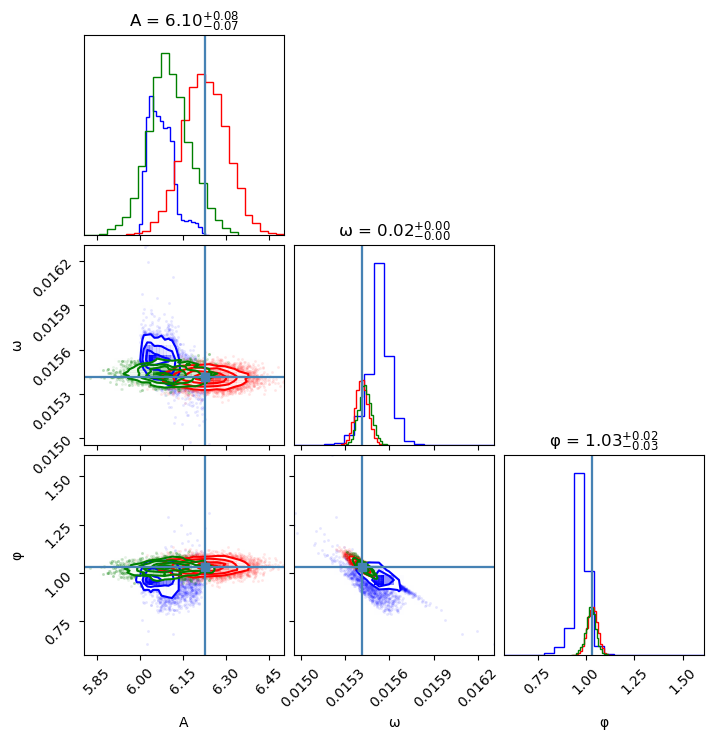

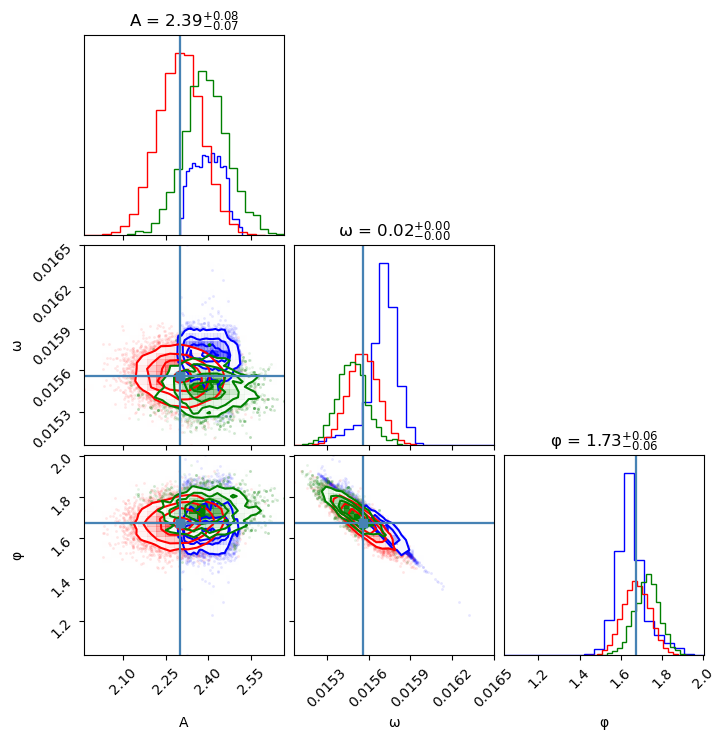

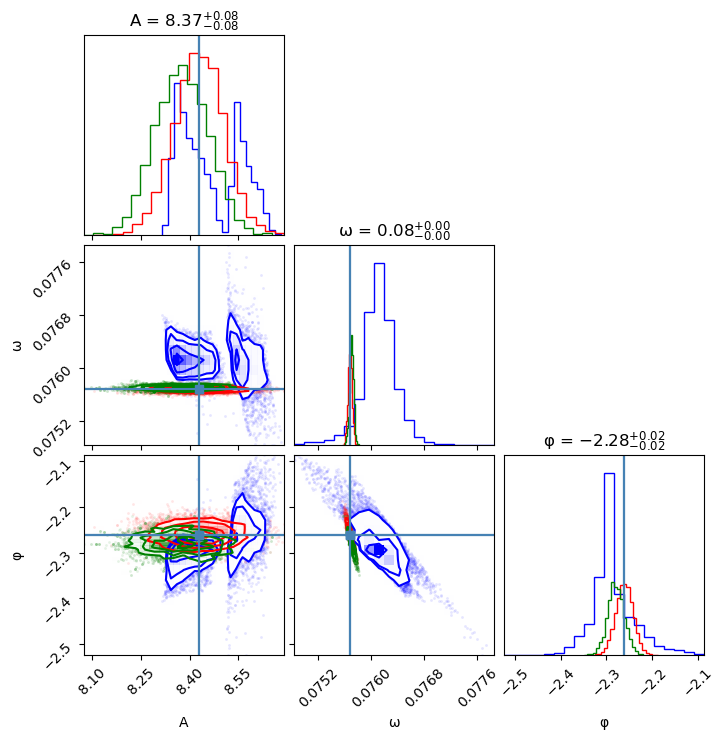

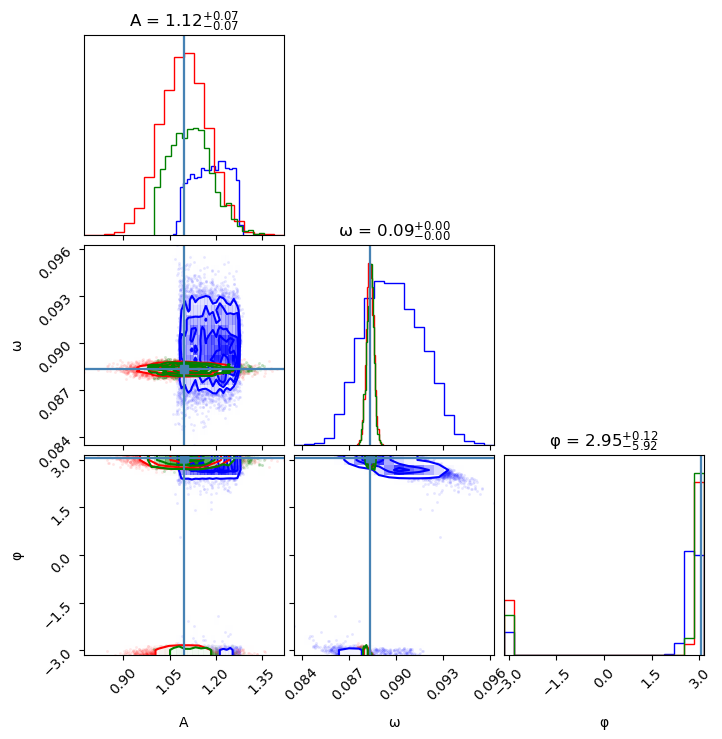

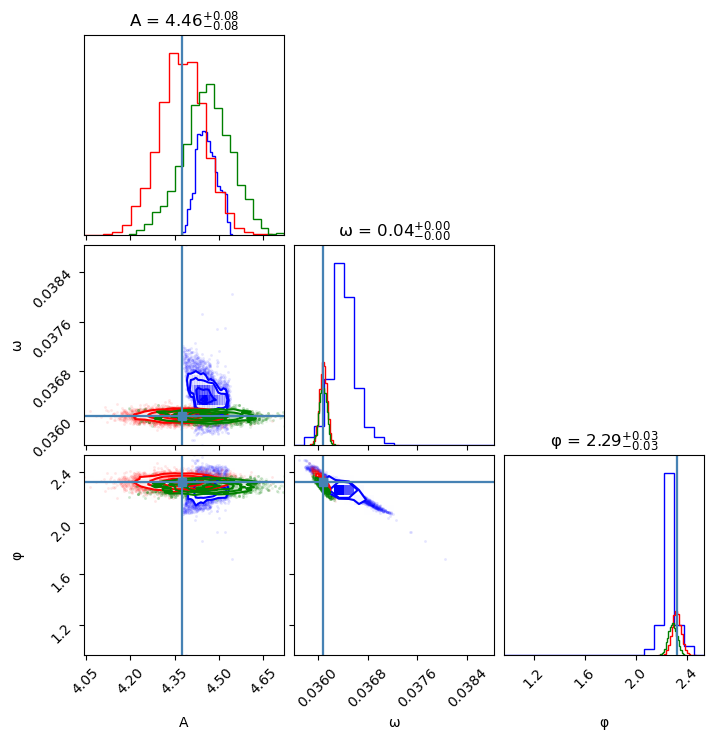

In [7]:
import corner
from mcmc import EmceeSampler

samples = 8 * 1024
plot_in_flow_space = False
for k in range(5):
    t, x0, x1, d = trainer.get_batch_fn(jr.key(k), samples)
    datastream = d[0]
    true_params = np.array(from_flow_space(x1[0]))

    # sample from prior
    x1_prior = np.array(x0)

    # sample using CNF
    print("SAMPLING USING CNF")
    xt = model.apply(params, x0, datastream, method="push")
    x1_cnf = np.array(from_flow_space(xt[-1]))

    # sample using FISHER
    print("SAMPLING USING FISHER")
    H = jax.hessian(lambda p: dataset.log_likelihood(p, datastream))
    cov = np.linalg.inv(H(true_params))
    x1_fisher = np.random.multivariate_normal(true_params, cov, len(x0))
    x1_fisher = np.array(from_flow_space(to_flow_space(x1_fisher)))

    # sample using MCMC
    print("SAMPLING USING MCMC")
    log_post = lambda p: dataset.log_likelihood(p, datastream) + dataset.log_prior(p)
    x1_mcmc = EmceeSampler(burn=1000, walkers=64, steps=samples // 64).run(
        log_prob=jax.jit(log_post), x0=true_params
    )
    x1_mcmc = np.array(from_flow_space(to_flow_space(x1_mcmc)))

    # plot corner
    if plot_in_flow_space:
        true_params, x1_cnf, x1_fisher, x1_mcmc = (
            np.array(to_flow_space(el))
            for el in (true_params, x1_cnf, x1_fisher, x1_mcmc)
        )
    corner_kwargs = dict(labels=["A", "ω", "φ"], show_titles=True, truths=true_params)
    fig = None  # corner.corner(x1_prior, color="black", **corner_kwargs)
    fig = corner.corner(x1_cnf, color="blue", fig=fig, **corner_kwargs)
    fig = corner.corner(x1_fisher, color="red", fig=fig, **corner_kwargs)
    fig = corner.corner(x1_mcmc, color="green", fig=fig, **corner_kwargs)